In [1]:
import pandas as pd
import torch
import json
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('/content/Ecare_2.json', 'r') as f:
    ecare_1 = [json.loads(line) for line in f]

# Define split sizes for a 75-25 split of the data
train_size = int(0.75 * len(ecare_1))
train_data = ecare_1[:train_size]
validation_data = ecare_1[train_size:]

class EcareDataset(Dataset):
    def __init__(self, ecare_data, tokenizer):
        self.ecare_data = ecare_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.ecare_data)

    def __getitem__(self, idx):
        data = self.ecare_data[idx]
        premise = data['premise']
        hypotheses = [data['hypothesis1'], data['hypothesis2']]
        label = data['label']

        encoded_input = self.tokenizer(premise, hypotheses, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        input_ids = encoded_input['input_ids'].squeeze(0)
        attention_mask = encoded_input['attention_mask'].squeeze(0)
        label = torch.tensor(label)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

ecare_dataset = EcareDataset(train_data, tokenizer)
dataloader = DataLoader(ecare_dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(3):
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

validation_dataset = EcareDataset(validation_data, tokenizer)
validation_dataloader = DataLoader(validation_dataset, batch_size=64)

model.eval()
y_true, y_pred, y_scores = [], [], []

def compute_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        y_scores_batch = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_scores.extend(y_scores_batch)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss: 0.694244921207428
Epoch: 0, Loss: 0.6711341738700867
Epoch: 0, Loss: 0.7176212668418884
Epoch: 0, Loss: 0.7425334453582764
Epoch: 0, Loss: 0.7151995301246643
Epoch: 0, Loss: 0.6892797946929932
Epoch: 0, Loss: 0.7057849764823914
Epoch: 0, Loss: 0.6969303488731384
Epoch: 0, Loss: 0.7042622566223145
Epoch: 0, Loss: 0.7068921327590942
Epoch: 0, Loss: 0.6654497981071472
Epoch: 0, Loss: 0.7071707844734192
Epoch: 0, Loss: 0.7095438838005066
Epoch: 0, Loss: 0.7534621357917786
Epoch: 0, Loss: 0.7109137773513794
Epoch: 0, Loss: 0.7023499011993408
Epoch: 0, Loss: 0.6878631711006165
Epoch: 0, Loss: 0.6767623424530029
Epoch: 0, Loss: 0.6873757839202881
Epoch: 0, Loss: 0.7201390266418457
Epoch: 0, Loss: 0.6949024796485901
Epoch: 0, Loss: 0.7128810882568359
Epoch: 0, Loss: 0.700084388256073
Epoch: 0, Loss: 0.7089475393295288
Epoch: 0, Loss: 0.6982067227363586
Epoch: 0, Loss: 0.6908289194107056
Epoch: 0, Loss: 0.7097020149230957
Epoch: 0, Loss: 0.696660578250885
Epoch: 0, Loss: 0.66839

In [2]:
# Calculate metrics
accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix = compute_metrics(y_true, y_pred, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MCC: {mcc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5760
F1: 0.2933
Precision: 0.6111
Recall: 0.1930
ROC-AUC: 0.5325
PR-AUC: 0.5394
MCC: 0.1277
Confusion Matrix:
[[122  14]
 [ 92  22]]


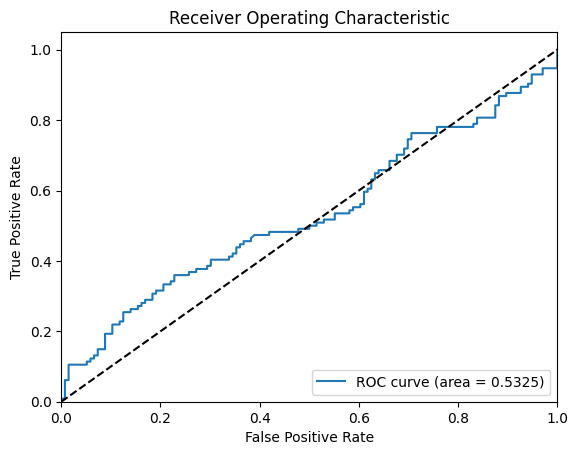

In [3]:
# Plot ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

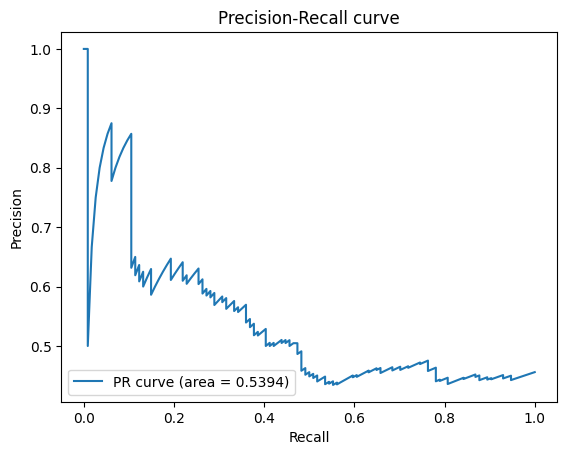

In [4]:
# Plot PR-AUC curve
precision_array, recall_array, _ = precision_recall_curve(y_true, y_scores)
plt.figure(2)
plt.plot(recall_array, precision_array, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()